In [ ]:
! pip install imbalanced-learn

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    balanced_accuracy_score, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
SEED = 23
np.random.seed(SEED)
torch.manual_seed(SEED)

batch_size   = 128
test_val_sz  = 0.2
num_epochs   = 40
lr           = 1e-3
weight_decay = 1e-4
patience     = 6
clip_norm    = 1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# transformation

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/SUMMER_RESEARCH/Data/imputed_data.csv')
if 'egoid' in data.columns:
    data = data.drop(columns='egoid')

target_col = 'target_depression'
X_df = data.drop(columns=['target_depression', 'target_anxiety', 'target_sleep'])
y_df = data[target_col].astype(int)


X_train_df, X_temp_df, y_train_df, y_temp_df = train_test_split(
    X_df, y_df, test_size=test_val_sz, random_state=SEED, stratify=y_df
)
X_val_df, X_test_df, y_val_df, y_test_df = train_test_split(
    X_temp_df, y_temp_df, test_size=0.5, random_state=SEED, stratify=y_temp_df
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df).astype(np.float32)
X_val   = scaler.transform(X_val_df).astype(np.float32)
X_test  = scaler.transform(X_test_df).astype(np.float32)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)

y_train_t = torch.tensor(y_train_df.values, dtype=torch.float32)
y_val_t   = torch.tensor(y_val_df.values,   dtype=torch.float32)
y_test_t  = torch.tensor(y_test_df.values,  dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t,   y_val_t)
test_dataset  = TensorDataset(X_test_t,  y_test_t)


dep = y_train_df.values.astype(int)
class_weights = 1.0 / np.bincount(dep)
sample_weights = class_weights[dep]
sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print('train size:', X_train.shape, '| val size:', X_val.shape, '| test size:', X_test.shape)


train size: (87521, 26) val size: (10940, 26) test size: (10941, 26)


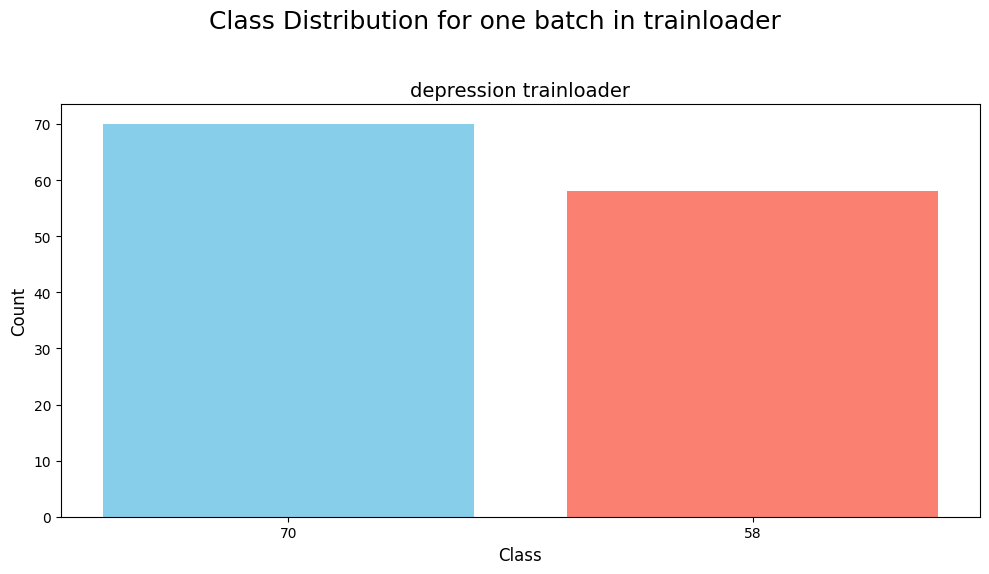

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharey=True)
fig.suptitle('Class Distribution for one batch in trainloader', fontsize=18)

target = next(iter(train_loader))[1]
counts = np.bincount(target)

axes.bar(counts.astype(str), counts, color=['skyblue', 'salmon'])
axes.set_title('depression trainloader', fontsize=14)
axes.set_xlabel('Class', fontsize=12)

axes.set_ylabel('Count', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

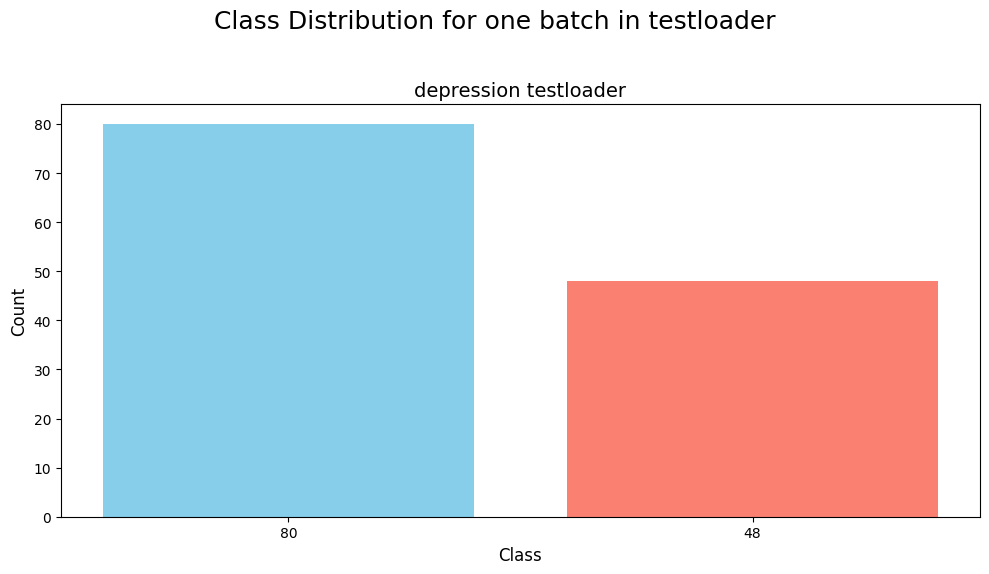

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharey=True)
fig.suptitle('Class Distribution for one batch in testloader', fontsize=18)

target = next(iter(test_loader))[1]
counts = np.bincount(target)

axes.bar(counts.astype(str), counts, color=['skyblue', 'salmon'])
axes.set_title('depression testloader', fontsize=14)
axes.set_xlabel('Class', fontsize=12)

axes.set_ylabel('Count', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# define model

In [ ]:
class DepressionNet(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1)
        )
        self.out = nn.Linear(32, 1)
        with torch.no_grad():
            p = float(y_train_df.mean())
            p = np.clip(p, 1e-4, 1-1e-4)
            self.out.bias.fill_(np.log(p/(1-p)))

    def forward(self, x):
        h = self.net(x)
        return self.out(h).squeeze(1)

# training

In [ ]:
model = DepressionNet(in_dim=X_train.shape[1]).to(device)

pos = int((y_train_df == 1).sum())
neg = int((y_train_df == 0).sum())
pos = max(pos, 1)
pos_weight = torch.tensor([neg / pos], dtype=torch.float32, device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
train_losses, val_losses = [], []
train_ba, val_ba = [], []

best_val_loss = float('inf')
best_state = None
es_counter = 0

for epoch in range(1, num_epochs+1):
    model.train()
    run_loss = 0.0
    t_pred, t_true = [], []

    for xb, yb in tqdm(train_loader, leave=False):
        xb = xb.to(device); yb = yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()

        run_loss += loss.item()
        t_pred.extend((torch.sigmoid(logits) > 0.5).long().cpu().numpy())
        t_true.extend(yb.cpu().numpy())

    tr_loss = run_loss / len(train_loader)
    train_losses.append(tr_loss)
    train_ba.append(balanced_accuracy_score(t_true, t_pred))

    model.eval()
    val_run_loss = 0.0
    v_logits, v_true = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_run_loss += loss.item()
            v_logits.extend(logits.cpu().numpy())
            v_true.extend(yb.cpu().numpy())

    v_loss = val_run_loss / len(val_loader)
    val_losses.append(v_loss)
    scheduler.step(v_loss)

    v_probs = 1/(1+np.exp(-np.array(v_logits)))
    v_pred  = (v_probs > 0.5).astype(int)
    val_ba.append(balanced_accuracy_score(v_true, v_pred))

    print(f"Epoch {epoch:02d} | Train Loss {tr_loss:.4f} | Val Loss {v_loss:.4f} | "
          f"Train BA {train_ba[-1]:.3f} | Val BA {val_ba[-1]:.3f}")

    if v_loss < best_val_loss - 1e-4:
        best_val_loss = v_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        es_counter = 0
    else:
        es_counter += 1
        if es_counter >= patience:
            print("Early stopping.")
            break

if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})


Epoch 01 | Train Loss 1.0480 | Val Loss 1.0393 | Train BA 0.536 | Val BA 0.523


Epoch 02 | Train Loss 0.9768 | Val Loss 1.0291 | Train BA 0.539 | Val BA 0.547


Epoch 03 | Train Loss 0.9703 | Val Loss 1.0341 | Train BA 0.543 | Val BA 0.535


Epoch 04 | Train Loss 0.9625 | Val Loss 1.0259 | Train BA 0.550 | Val BA 0.549


Epoch 05 | Train Loss 0.9547 | Val Loss 1.0183 | Train BA 0.558 | Val BA 0.553


Epoch 06 | Train Loss 0.9504 | Val Loss 0.9912 | Train BA 0.560 | Val BA 0.563


Epoch 07 | Train Loss 0.9453 | Val Loss 1.0129 | Train BA 0.564 | Val BA 0.558


Epoch 08 | Train Loss 0.9403 | Val Loss 0.9880 | Train BA 0.568 | Val BA 0.571


Epoch 09 | Train Loss 0.9417 | Val Loss 1.0031 | Train BA 0.569 | Val BA 0.568


Epoch 10 | Train Loss 0.9341 | Val Loss 0.9667 | Train BA 0.573 | Val BA 0.577


Epoch 11 | Train Loss 0.9305 | Val Loss 0.9513 | Train BA 0.577 | Val BA 0.589


Epoch 12 | Train Loss 0.9292 | Val Loss 0.9791 | Train BA 0.575 | Val BA 0.579


Epoch 13 | Train Loss 0.9263 | Val Loss 0.9654 | Train BA 0.581 | Val BA 0.580


Epoch 14 | Train Loss 0.9230 | Val Loss 0.9737 | Train BA 0.583 | Val BA 0.581


Epoch 15 | Train Loss 0.9211 | Val Loss 0.9568 | Train BA 0.585 | Val BA 0.592


Epoch 16 | Train Loss 0.9170 | Val Loss 0.9529 | Train BA 0.586 | Val BA 0.591


Epoch 17 | Train Loss 0.9120 | Val Loss 0.9521 | Train BA 0.592 | Val BA 0.594
Early stopping.


# plotting training and val loss and accuracy

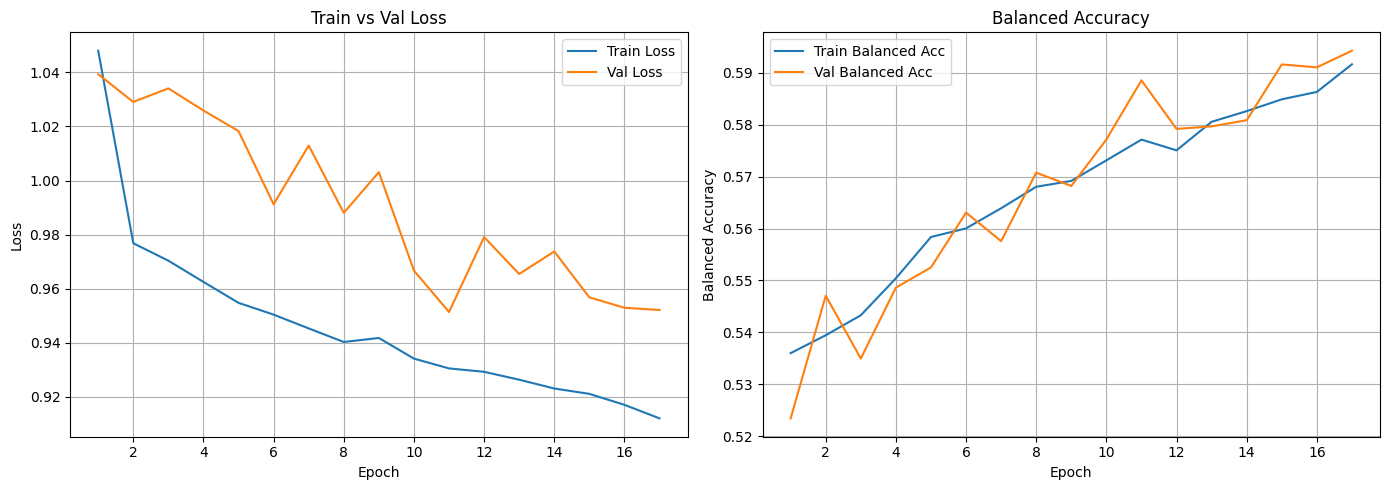

In [ ]:
epochs = range(1, len(train_losses)+1)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(epochs, train_losses, label='Train Loss')
axes[0].plot(epochs, val_losses,   label='Val Loss')
axes[0].set_title('Train vs Val Loss'); axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].grid(True); axes[0].legend()

axes[1].plot(epochs, train_ba, label='Train Balanced Acc')
axes[1].plot(epochs, val_ba,   label='Val Balanced Acc')
axes[1].set_title('Balanced Accuracy'); axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Balanced Accuracy')
axes[1].grid(True); axes[1].legend()

plt.tight_layout(); plt.show()


In [ ]:
def best_threshold_for_BA(y_true, logits):
    probs = 1.0 / (1.0 + np.exp(-np.array(logits)))
    fpr, tpr, th = roc_curve(y_true, probs)
    if len(th) == 0:
        return 0.5
    j = tpr - fpr
    th_j = th[np.argmax(j)]
    p, r, th_pr = precision_recall_curve(y_true, probs)
    if len(th_pr) > 0:
        f1 = (2*p*r)/(p+r+1e-12)
        th_f1 = th_pr[np.argmax(f1[:-1])]
        return float(np.nan_to_num(th_j, nan=th_f1))
    return float(th_j)

model.eval()
val_logits, val_true = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        lg = model(xb)
        val_logits.extend(lg.cpu().numpy())
        val_true.extend(yb.numpy())

th = best_threshold_for_BA(val_true, val_logits)
print("Chosen threshold (depression):", round(th, 3))

Chosen threshold (depression): 0.695



==== Test Metrics: Depression ====
Balanced Accuracy: 0.660
ROC AUC:           0.719
PR AUC:            0.529


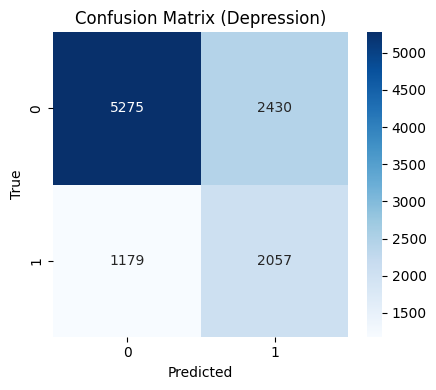

In [ ]:
model.eval()
test_true, test_prob, test_pred = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        lg = model(xb)
        p = torch.sigmoid(lg).cpu().numpy()
        test_prob.extend(p)
        test_pred.extend((p > th).astype(int))
        test_true.extend(yb.numpy())

ba  = balanced_accuracy_score(test_true, test_pred)
roc = roc_auc_score(test_true, test_prob)
pr  = average_precision_score(test_true, test_prob)

print("\n==== Test Metrics: Depression ====")
print(f"Balanced Accuracy: {ba:.3f}")
print(f"ROC AUC:           {roc:.3f}")
print(f"PR AUC:            {pr:.3f}")

# Confusion matrix
cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(4.5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Depression)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.show()